In [ ]:
! pip install -q tensorflow-gpu

In [ ]:
import tensorflow as tf

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
device_name = "/device:GPU:0"

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
def make_generator_network(num_hidden_layers=1,
                           num_hidden_units=100,
                           num_output_units=784):
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(units=num_hidden_units, use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dense(units=num_output_units, activation=tf.keras.activations.tanh))
  return model

In [ ]:
def make_discriminator_network(num_hidden_layers=1,
                               num_hidden_units=100,
                               num_output_units=1):
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(units=num_hidden_units))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate=0.5))
  model.add(tf.keras.layers.Dense(units=num_output_units, activation=None))
  return model

In [ ]:
num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform' # options: 'uniform' and 'normal'
gen_hidden_layers = 1
gen_hidden_units = 100
disc_hidden_layers = 1
disc_hidden_units = 100

tf.random.set_seed(1)
np.random.seed(1)

In [ ]:
gen_model = make_generator_network(num_hidden_layers=gen_hidden_layers, num_hidden_units=gen_hidden_units)
gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             multiple                  2000      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dense_17 (Dense)             multiple                  79184     
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [ ]:
disc_model = make_discriminator_network(num_hidden_layers=disc_hidden_layers,
                                        num_hidden_units=disc_hidden_units)
disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             multiple                  78500     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_19 (Dense)             multiple                  101       
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

In [ ]:
def preprocess(ex, mode='uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.reshape(image, [-1])
  if mode == 'uniform':
    input_z = tf.random.uniform(shape=(z_size,), minval=-1.0, maxval=1.0)
  elif mode == 'normal':
    input_z = tf.random.normal(shape=(z_size,))
  return input_z, image

In [ ]:
mnist_trainset = mnist['train'].map(preprocess).batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
g_output = gen_model(input_z)
d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)

print('input_z -> shape:', input_z.shape)
print('input_real -> shape:', input_real.shape)
print('Output of G -> shape:', g_output.shape)
print('Disc. (real) -> shape:', d_logits_real.shape)
print('Disc. (fake) -> shape:', d_logits_fake.shape)

input_z -> shape: (32, 20)
input_real -> shape: (32, 784)
Output of G -> shape: (32, 784)
Disc. (real) -> shape: (32, 1)
Disc. (fake) -> shape: (32, 1)


In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('Generator Loss: {:.4f}'.format(g_loss))

Generator Loss: 0.7355


In [ ]:
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)
d_loss_real = loss_fn(y_true=d_labels_real,
                      y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake,
                      y_pred=d_logits_fake)
print('Discriminator Losses: Real {:.4f} Fake {:.4f}'.format(d_loss_real.numpy(), d_loss_fake.numpy()))

Discriminator Losses: Real 0.5997 Fake 0.6583


In [ ]:
def create_samples(g_model, input_z):
  g_output = g_model(input_z, training=False)
  images = tf.reshape(g_output, (batch_size, *image_size))
  return (images + 1) / 2.0

In [ ]:
if mode_z == 'uniform':
  fixed_z = tf.random.uniform(shape=(batch_size, z_size), minval=1, maxval=1)
elif mode_z == 'normal':
  fixed_z = tf.random.normal(shape=(batch_size, z_size))

In [ ]:
mnist_trainset = mnist['train'].map(
    lambda ex: preprocess(ex, mode=mode_z)).shuffle(10000).batch(batch_size, drop_remainder=True)

In [ ]:
with tf.device(device_name):
  gen_model = make_generator_network(num_hidden_layers=gen_hidden_layers,
                                     num_hidden_units=gen_hidden_units,
                                     num_output_units=np.prod(image_size))
  gen_model.build(input_shape=(None, z_size))

  disc_model = make_discriminator_network(num_hidden_layers=disc_hidden_layers,
                                          num_hidden_units=disc_hidden_units)
  disc_model.build(input_shape=(None, np.prod(image_size)))

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

In [78]:
start_time = time.time()
for epoch in range(1, num_epochs + 1):
  epoch_losses, epoch_d_vals = [], []
  for i, (input_z, input_real) in enumerate(mnist_trainset):
    # Compute Generator's Loss
    with tf.GradientTape() as g_tape:
      g_output = gen_model(input_z)
      d_logits_fake = disc_model(g_output, training=True)
      labels_real = tf.ones_like(d_logits_fake)
      g_loss = loss_fn(y_true=labels_real,
                       y_pred=d_logits_fake)
    
    # Compute the gradients of g_loss
    g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
    
    # Apply the gradients
    g_optimizer.apply_gradients(grads_and_vars=zip(g_grads, gen_model.trainable_variables))

    # Compute Discriminator's Loss
    with tf.GradientTape() as d_tape:
      d_logits_real = disc_model(input_real, training=True)
      d_labels_real = tf.ones_like(d_logits_real)
      d_loss_real = loss_fn(y_true=d_labels_real,
                            y_pred=d_logits_real)
      
      d_logits_fake = disc_model(g_output, training=True)
      d_labels_fake = tf.zeros_like(d_logits_fake)
      d_loss_fake = loss_fn(y_true=d_labels_fake,
                            y_pred=d_logits_fake)
      d_loss = d_loss_real + d_loss_fake
    
    # Compute the gradient of d_loss
    d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)

    # Apply the gradients 
    d_optimizer.apply_gradients(grads_and_vars=zip(d_grads, disc_model.trainable_variables))

    epoch_losses.append((g_loss.numpy(), d_loss.numpy(),
                      d_loss_real.numpy(), d_loss_fake.numpy()))
    d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
    d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
    epoch_d_vals.append((d_probs_real.numpy(),
                          d_probs_fake.numpy()))
    
  all_losses.append(epoch_losses)
  all_d_vals.append(epoch_d_vals)

  print('Epoch {:03d} | ET {:.2f} min | Avg Losses >> G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
  .format(epoch, (time.time() - start_time)/60, *list(np.mean(all_losses[-1], axis=0))))
  epoch_samples.append(create_samples(gen_model, fixed_z.numpy()))

Epoch 001 | ET 0.63 min | Avg Losses >> G/D 2.3226/0.8445 [D-Real: 0.3254 D-Fake: 0.5191]
Epoch 002 | ET 1.26 min | Avg Losses >> G/D 2.5307/0.9669 [D-Real: 0.4584 D-Fake: 0.5085]
Epoch 003 | ET 1.88 min | Avg Losses >> G/D 1.9707/0.9784 [D-Real: 0.4516 D-Fake: 0.5268]
Epoch 004 | ET 2.51 min | Avg Losses >> G/D 2.1731/1.0048 [D-Real: 0.4651 D-Fake: 0.5396]
Epoch 005 | ET 3.15 min | Avg Losses >> G/D 2.2855/0.9599 [D-Real: 0.4456 D-Fake: 0.5143]
Epoch 006 | ET 3.77 min | Avg Losses >> G/D 2.3204/0.9723 [D-Real: 0.4525 D-Fake: 0.5198]
Epoch 007 | ET 4.41 min | Avg Losses >> G/D 2.0418/0.9877 [D-Real: 0.4719 D-Fake: 0.5158]
Epoch 008 | ET 5.03 min | Avg Losses >> G/D 2.1473/1.0737 [D-Real: 0.4784 D-Fake: 0.5953]
Epoch 009 | ET 5.66 min | Avg Losses >> G/D 1.8444/1.0927 [D-Real: 0.5004 D-Fake: 0.5924]
Epoch 010 | ET 6.29 min | Avg Losses >> G/D 2.0261/1.0197 [D-Real: 0.4772 D-Fake: 0.5425]
Epoch 011 | ET 6.92 min | Avg Losses >> G/D 1.9643/1.0424 [D-Real: 0.4840 D-Fake: 0.5584]
Epoch 012 

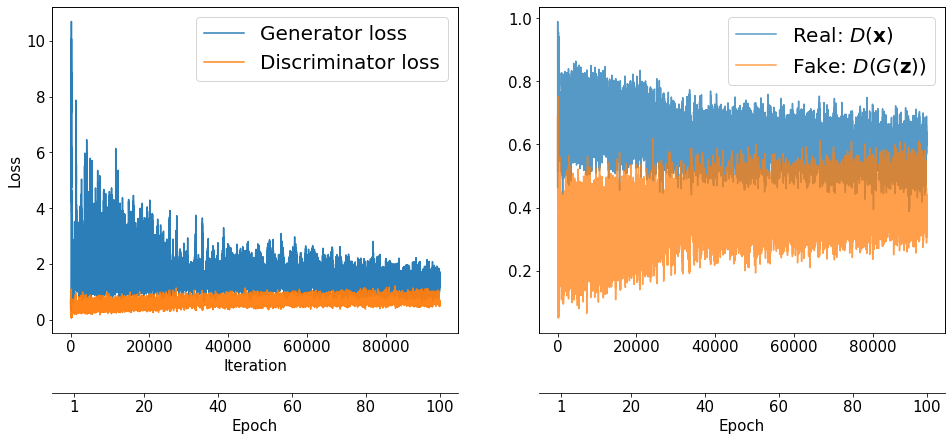

In [79]:
import itertools

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]

plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epochs2iter = lambda e: e * len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epochs2iter(e) for e in epoch_ticks]

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75,
         label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75,
         label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

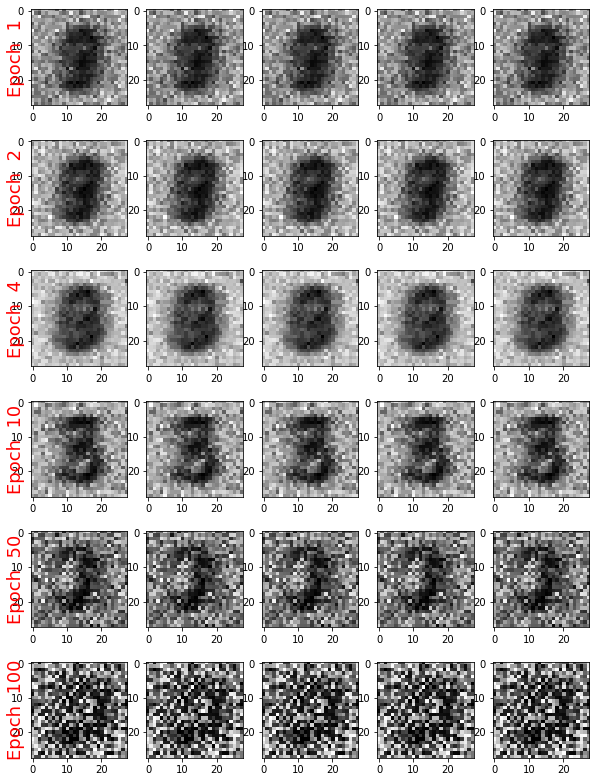

In [80]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i * 5 + j + 1)
    if j == 0: 
      ax.text(-0.06, 0.5, 'Epoch  {}'.format(e),
              rotation=90, size=18, color='red',
              horizontalalignment='right',
              verticalalignment='center',
              transform=ax.transAxes)
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')
plt.show()

In [82]:
disc_model.save('disc_model')
gen_model.save('gen_model')

INFO:tensorflow:Assets written to: disc_model/assets


INFO:tensorflow:Assets written to: disc_model/assets


INFO:tensorflow:Assets written to: gen_model/assets


INFO:tensorflow:Assets written to: gen_model/assets
